# Installs/Imports

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 18.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found

In [2]:
# System and file handling
# import sys
import os
# import re
import glob
import random
import yaml
import shutil
from shutil import copyfile
import json

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.spatial.distance import jensenshannon
import time

# Image processing and display
import IPython.display as display
from PIL import Image
import cv2

# YOLO model from Ultralytics
import ultralytics
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
ultralytics.checks()

Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6281.6/8062.4 GB disk)


In [4]:
# No Weights & Biases (W&B)
! wandb disabled

W&B disabled.


In [5]:
class CFG:
    DEBUG = False
    # DEBUG = True
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    TARGET_RATIOS = {'train': 0.80, 'valid': 0.15, 'test': 0.05}

    # classes
    # Class map from dataset description
    PPE_CLASSES = {
        0: "Hardhat",
        1: "Mask",
        2: "NO-Hardhat",
        3: "NO-Mask",
        4: "NO-Safety Vest",
        5: "Person",
        6: "Safety Cone",
        7: "Safety Vest",
        8: "Machinery",
        9: "Vehicle"
    }
    # NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 30 # 100
    BATCH_SIZE = 4 if DEBUG else 12
    IMGSZ = 640  # Redimensiona para 640x640
    RECT = False # or True -> but makes shuffle = false due imcompatibility 
    VERBOSE = False # Suppress detailed logs
    SHOW_LABELS = False # Hide labels in console output
    SHOW_CONF = False # Hide confidence scores in output
    SHOW_BOXES = False # Hide bounding boxes in terminal output
    BASE_MODEL = 'yolo11n.pt' # 'yolo11n.pt' 'yolo11s.pt' 'yolo11l.pt' 'yolo11x.pt'
    DEVICE = "cuda"

    # paths
    CSS_DATA_PATH = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data'
    OUTPUT_PATH = './'
    WORKING_PATH = "/kaggle/working/"
    FOLDERS = ["train", "valid", "test"]

    # Define the path to save the training results
    TRAIN_RESULTS = f"{WORKING_PATH}/train_results.csv"
    MODEL_PATH = f'{WORKING_PATH}/runs/detect/train/weights/best.pt'
    OUTPUT_MODEL_PATH = f'{WORKING_PATH}/best.pt'
    METADATA_PATH = f'{WORKING_PATH}/metadata.json'

# EDA

## Directoy contents

In [7]:
for folder in CFG.FOLDERS:
    image_path = os.path.join(CFG.CSS_DATA_PATH, folder, "images")
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")

    images = set(f.rsplit(".", 1)[0] for f in os.listdir(image_path) if f.endswith((".jpg", ".png")))
    labels = set(f.rsplit(".", 1)[0] for f in os.listdir(label_path) if f.endswith(".txt"))

    missing_labels = images - labels  # Imagens sem labels
    missing_images = labels - images  # Labels sem imagens

    print(f"📂 {folder.upper()} SET:")
    print(f" - Total Images: {len(images)}")
    print(f" - Total Labels: {len(labels)}")
    print(f" - Sample Image Names: {list(images)[:2]}")
    print(f" - Sample Label Names: {list(labels)[:2]}")
    print(f" - Missing Labels: {len(missing_labels)} → {list(missing_labels)[:2]}")
    print(f" - Missing Images: {len(missing_images)} → {list(missing_images)[:2]}")
    print(" ")

📂 TRAIN SET:
 - Total Images: 2605
 - Total Labels: 2605
 - Sample Image Names: ['youtube-242_jpg.rf.ecfb577d7a9e7a35dcc60b16ec4d47f4', 'construction-3-_mp4-162_jpg.rf.d5b9deac1a1c1205d223e3d604afdd09']
 - Sample Label Names: ['youtube-242_jpg.rf.ecfb577d7a9e7a35dcc60b16ec4d47f4', 'construction-3-_mp4-162_jpg.rf.d5b9deac1a1c1205d223e3d604afdd09']
 - Missing Labels: 0 → []
 - Missing Images: 0 → []
----------------------------------------
📂 VALID SET:
 - Total Images: 114
 - Total Labels: 114
 - Sample Image Names: ['youtube-584_jpg.rf.3136186a0786384c1ffc261f4d40ea42', 'youtube-277_jpg.rf.1bda1581c28b4f6cccd5eda6b23b94ee']
 - Sample Label Names: ['youtube-584_jpg.rf.3136186a0786384c1ffc261f4d40ea42', 'youtube-118_jpg.rf.9dc8b46dfbac73d9e4f983964355d7ac']
 - Missing Labels: 0 → []
 - Missing Images: 0 → []
----------------------------------------
📂 TEST SET:
 - Total Images: 82
 - Total Labels: 82
 - Sample Image Names: ['image_53_jpg.rf.3446e366b5d4d905a32e1aedc8fe87de', 'youtube-253_j

## Lables

In [8]:
# Number of label files to display per folder
num_samples = 3

# Read label files from each folder
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    print(f"📂 {folder.upper()} LABELS CONTENT:")

    # Display content of up to num_samples label files
    for label_file in label_files[:num_samples]:
        file_path = os.path.join(label_path, label_file)

        with open(file_path, "r") as f:
            content = f.readlines()

        print(f"📄 {label_file}:")
        for line in content:
            print(f"  {line.strip()}")  # Display without extra line breaks
        print("-" * 50)

📂 TRAIN LABELS CONTENT:
📄 youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03e2053.txt:
  9 0.56171875 0.0234375 0.0578125 0.046875
  5 0.20703125 0.1703125 0.0328125 0.0859375
  7 0.21171875 0.165625 0.0140625 0.03125
  8 0.2125 0.26953125 0.425 0.5390625
  4 0.8 0.178125 0.4 0.35625
  1 0.865625 0.16875 0.26875 0.30625
  5 0.8 0.309375 0.4 0.61875
  8 0.35 0.88125 0.284375 0.2375
  9 0.8 0.809375 0.4 0.38125
--------------------------------------------------
📄 Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1d22b.txt:
  8 0.15078125 0.18203125 0.3015625 0.3640625
  6 0.6087540979471843 0.8078125 0.05098179201145392 0.084375
  6 0.5584546532861385 0.76640625 0.027144302673454135 0.05
  6 0.5972267992918655 0.72421875 0.02236589600572696 0.0421875
  6 0.5509694172899565 0.73828125 0.02231135200509069 0.0375
  6 0.12307004193191222 0.9203125 0.05268974267981754 0.096875
  6 0.19350126794241174 0.84296875 0.03829997867599957 0.06875
  6 0.2556745512810479 0.80390625 0.030323846674090583 0.054687

## Classes along the dataset

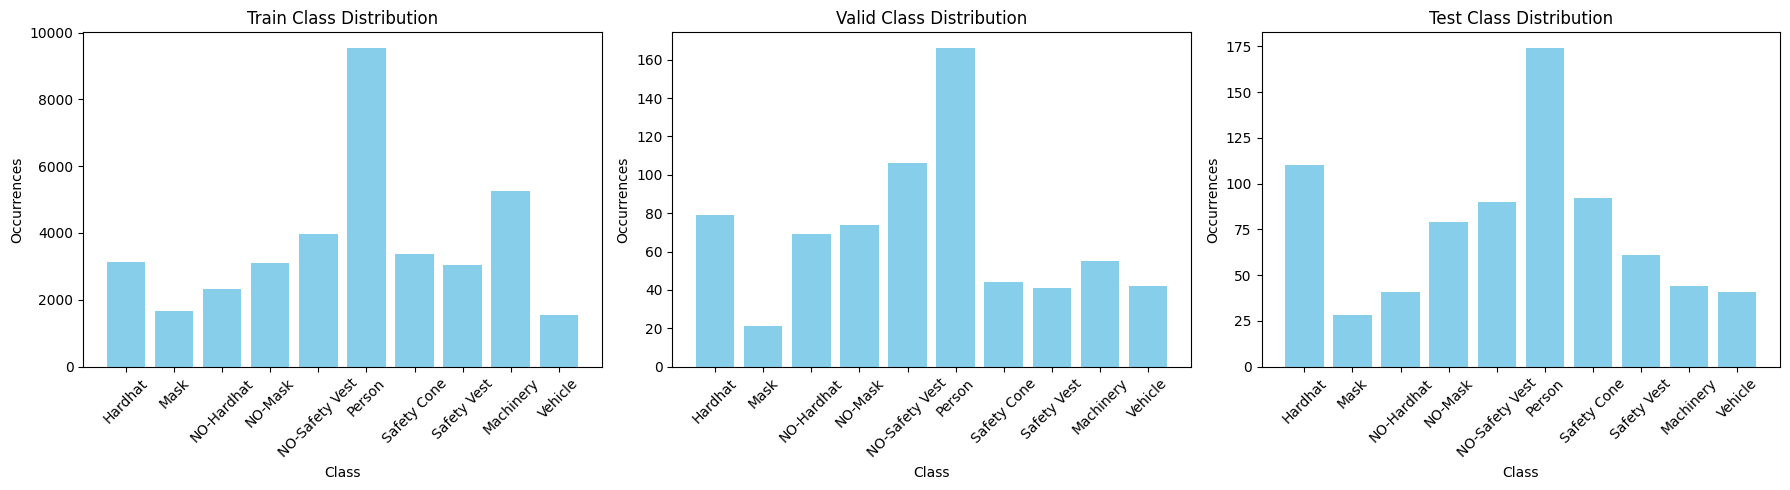

In [9]:
# Initialize class counters
class_counts = {folder: {cls: 0 for cls in CFG.PPE_CLASSES.keys()} for folder in CFG.FOLDERS}

# Count occurrences of each class in train and validation datasets
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    for label_file in label_files:
        file_path = os.path.join(label_path, label_file)
        
        with open(file_path, "r") as f:
            lines = f.readlines()
        
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID from each annotation
            class_counts[folder][class_id] += 1  # Increment class count

# Plot class distribution with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjust for three plots

for i, folder in enumerate(CFG.FOLDERS):
    counts = class_counts[folder]
    classes = [CFG.PPE_CLASSES[k] for k in counts.keys()]
    values = list(counts.values())

    axes[i].bar(classes, values, color="skyblue")
    axes[i].set_title(f"{folder.capitalize()} Class Distribution")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Occurrences")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

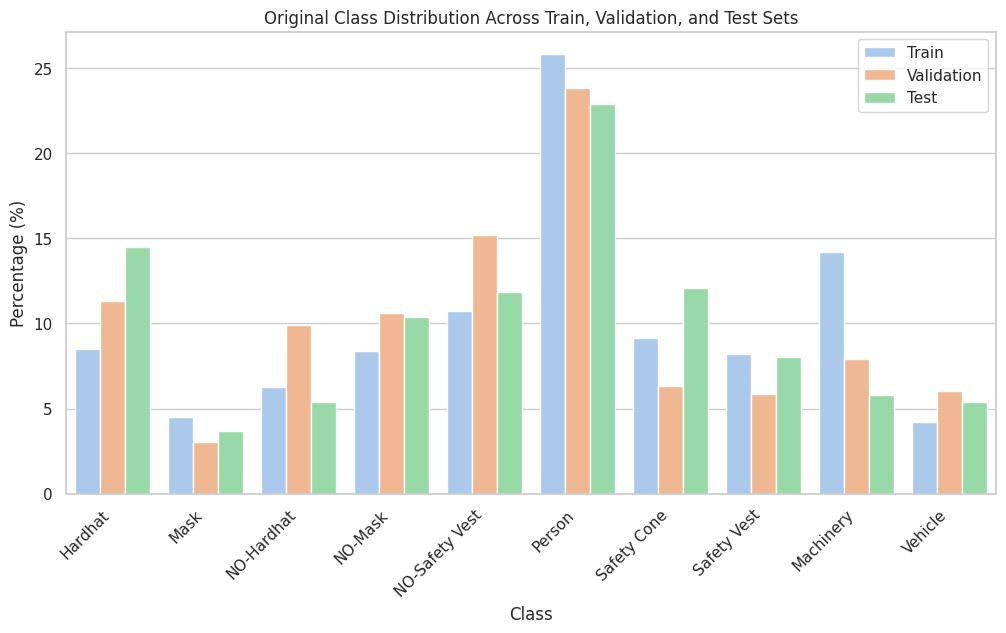

In [10]:
# Initialize class counters
class_counts = {folder: {cls: 0 for cls in CFG.PPE_CLASSES.keys()} for folder in CFG.FOLDERS}

# Count occurrences of each class in train, validation, and test datasets
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    for label_file in label_files:
        file_path = os.path.join(label_path, label_file)
        
        with open(file_path, "r") as f:
            lines = f.readlines()
        
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID from each annotation
            class_counts[folder][class_id] += 1  # Increment class count

# Convert to percentages
class_percentages = {
    folder: {cls: (count / sum(class_counts[folder].values())) * 100 if sum(class_counts[folder].values()) > 0 else 0
             for cls, count in class_counts[folder].items()}
    for folder in CFG.FOLDERS
}

# Convert to DataFrame for plotting
df_plot = pd.DataFrame({
    "Class": list(CFG.PPE_CLASSES.values()) * 3,  # Repeat classes for each dataset
    "Percentage": list(class_percentages["train"].values()) + 
                  list(class_percentages["valid"].values()) + 
                  list(class_percentages["test"].values()),
    "Dataset": ["Train"] * len(class_percentages["train"]) + 
               ["Validation"] * len(class_percentages["valid"]) + 
               ["Test"] * len(class_percentages["test"])
})

# Set theme and color palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("pastel")

# Plot using sns.barplot()
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Percentage", hue="Dataset", data=df_plot, palette=palette)

# Labels and formatting
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Original Class Distribution Across Train, Validation, and Test Sets")
plt.xticks(rotation=45, ha="right")
plt.legend()

# Show the plot
plt.show()


In [11]:
# Convert to percentages
class_percentages = {
    folder: {cls: (count / sum(class_counts[folder].values())) * 100 if sum(class_counts[folder].values()) > 0 else 0
             for cls, count in class_counts[folder].items()}
    for folder in CFG.FOLDERS
}

# Convert percentages to arrays
train_dist = np.array(list(class_percentages["train"].values()))
valid_dist = np.array(list(class_percentages["valid"].values()))
test_dist = np.array(list(class_percentages["test"].values()))

# Compute standard deviation (spread of the distribution)
train_std = np.std(train_dist)
valid_std = np.std(valid_dist)
test_std = np.std(test_dist)

# Compute Coefficient of Variation (CV) for each dataset
train_cv = (train_std / np.mean(train_dist)) * 100
valid_cv = (valid_std / np.mean(valid_dist)) * 100
test_cv = (test_std / np.mean(test_dist)) * 100

# Compute Jensen-Shannon Divergence
jsd_train_valid = jensenshannon(train_dist, valid_dist)
jsd_train_test = jensenshannon(train_dist, test_dist)

# Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Train: {train_std:.2f}, Valid: {valid_std:.2f}, Test: {test_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Train: {train_cv:.2f}%, Valid: {valid_cv:.2f}%, Test: {test_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better):")
print(f"   Train vs Valid: {jsd_train_valid:.4f}, Train vs Test: {jsd_train_test:.4f}")

📊 Standard Deviation of Class Distribution:
   Train: 5.97, Valid: 5.66, Test: 5.46

📊 Coefficient of Variation (Lower is better):
   Train: 59.66%, Valid: 56.55%, Test: 54.61%

📊 Jensen-Shannon Divergence (Lower is better):
   Train vs Valid: 0.1193, Train vs Test: 0.1264


In [12]:
# Initialize an empty dictionary to store class counts
classes_dict = {}

# Iterate over dataset splits
for subset_folder in CFG.FOLDERS:
    label_folder = glob.glob(os.path.join(CFG.CSS_DATA_PATH, subset_folder, 'labels', '*.txt'))
    cl = []
    
    # Read annotation files
    for anno_file in label_folder:
        with open(anno_file, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
            cl.extend([line.split()[0] for line in lines])  # Extract class ID correctly
    
    # Count occurrences of each class
    cl_count = {str(c): cl.count(str(c)) for c in range(10)}  # Ensure all classes (0-9) are included
    classes_dict[subset_folder] = cl_count

# Convert dictionary to DataFrame
df_class_distribution = pd.DataFrame(classes_dict).fillna(0).astype(int)

# Rename index to represent class names
df_class_distribution.index.name = "Class ID"

# Print the DataFrame
print(df_class_distribution)

          train  valid  test
Class ID                    
0          3145     79   110
1          1651     21    28
2          2317     69    41
3          3097     74    79
4          3962    106    90
5          9532    166   174
6          3366     44    92
7          3033     41    61
8          5247     55    44
9          1545     42    41


In [13]:
# Classes from PPE dataset (0-9)
classes = list(CFG.PPE_CLASSES.keys())

# Initialize an empty list to store image metadata
data = []

# Iterate over train, valid, and test folders
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, 'labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    for label_file in label_files:
        # Extract image filename (without extension)
        img_name = os.path.basename(label_file).replace('.txt', '')

        # Read the label file and count occurrences of each class
        class_counts = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}  # Initialize all classes with 0
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # Extract class ID
                class_counts[class_id] += 1  # Count occurrences

        # Create a row with the filename, origin, and class occurrences
        row = {'filename': img_name, 'origin': folder}
        row.update(class_counts)

        # Append to the dataset
        data.append(row)

# Convert list to DataFrame
df_total = pd.DataFrame(data)

# Print dataset summary
print(f"📊 Total images: {len(df_total)}")
print(df_total.head())

📊 Total images: 2801
                                            filename origin  0  1  2  3  4  5  \
0  youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03...  train  0  1  0  0  1  2   
1  Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1...  train  0  0  1  1  1  1   
2  youtube-693_jpg.rf.c5a5784a786a21f09fa8df370f7...  train  1  0  0  1  0  3   
3  IMG_0871_mp4-10_jpg.rf.316b943fdf8f56161e0005b...  train  0  2  0  0  2  2   
4  ka_00884_png_jpg.rf.7e1eb708ba18a96826b2667c8d...  train  0  0  1  1  0  1   

    6  7  8  9  
0   0  1  2  2  
1  12  0  1  3  
2   2  2  2  1  
3   0  0  2  0  
4   3  1  4  0  


In [14]:
df_total.describe()

,0,1,2,3,4,5,6,7,8,9
count,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000
mean,1.190289,0.606926,0.866476,1.160300,1.484470,3.524456,1.250268,1.119243,1.908604,0.581221
std,2.282822,1.019143,1.256421,1.824342,1.627177,2.903359,4.419258,2.203258,1.744236,1.426506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,1.000000,1.000000,2.000000,2.000000,4.000000,0.000000,1.000000,3.000000,1.000000
max,22.000000,10.000000,13.000000,21.000000,16.000000,24.000000,46.000000,20.000000,13.000000,15.000000


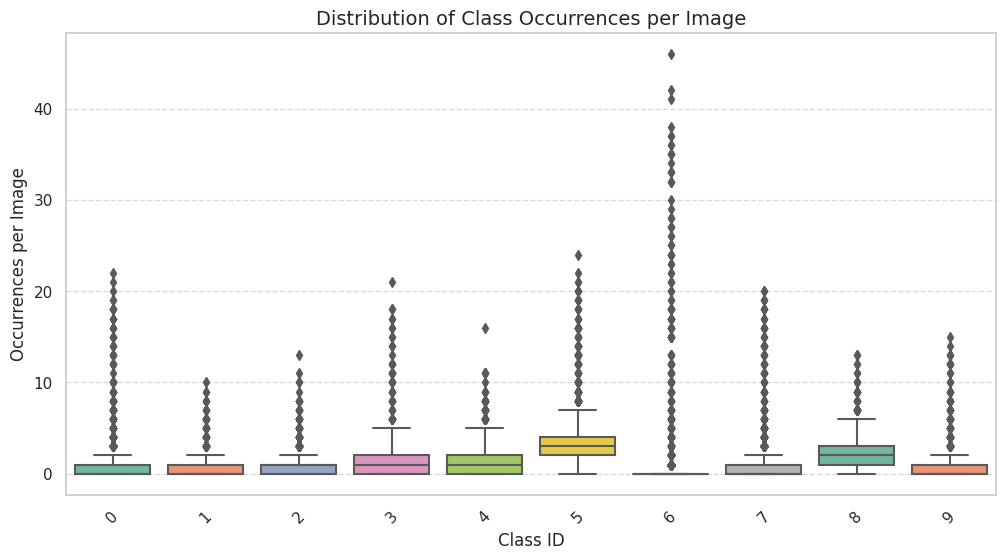

In [15]:
# Set figure size
plt.figure(figsize=(12, 6))

# Create boxplot
sns.boxplot(data=df_total.iloc[:, 2:], palette="Set2")

# Set title and labels
plt.title("Distribution of Class Occurrences per Image", fontsize=14)
plt.xlabel("Class ID", fontsize=12)
plt.ylabel("Occurrences per Image", fontsize=12)

# Show plot
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Fixing the Datasets

## 1. Total_df

In [16]:
# Classes from PPE dataset (0-9)
classes = list(CFG.PPE_CLASSES.keys())

# Initialize an empty list to store image metadata
data = []

# Iterate over train, valid, and test folders
for folder in CFG.FOLDERS:
    label_path = os.path.join(CFG.CSS_DATA_PATH, folder, 'labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    for label_file in label_files:
        # Extract image filename (without extension)
        img_name = os.path.basename(label_file).replace('.txt', '')

        # Initialize class presence as 0 for all classes
        class_presence = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}

        # Read the label file and mark presence of each class
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # Extract class ID
                class_presence[class_id] = 1  # Mark presence (1)

        # Create a row with the filename, origin, and class presence
        row = {'filename': img_name, 'origin': folder}
        row.update(class_presence)

        # Append to the dataset
        data.append(row)

# Convert list to DataFrame
df_total = pd.DataFrame(data)

# Print dataset summary
print(f"📊 Total images: {len(df_total)}")
print(df_total.head())

📊 Total images: 2801
                                            filename origin  0  1  2  3  4  5  \
0  youtube-270_jpg.rf.9ae5283f885f67c55f351ac2d03...  train  0  1  0  0  1  1   
1  Image_1009_jpg.rf.42a85f154507fc3c69facf93bbb1...  train  0  0  1  1  1  1   
2  youtube-693_jpg.rf.c5a5784a786a21f09fa8df370f7...  train  1  0  0  1  0  1   
3  IMG_0871_mp4-10_jpg.rf.316b943fdf8f56161e0005b...  train  0  1  0  0  1  1   
4  ka_00884_png_jpg.rf.7e1eb708ba18a96826b2667c8d...  train  0  0  1  1  0  1   

   6  7  8  9  
0  0  1  1  1  
1  1  0  1  1  
2  1  1  1  1  
3  0  0  1  0  
4  1  1  1  0  


In [17]:
# Create empty lists to store rows for each dataset
train_data = []
valid_data = []
test_data = []

# Define target proportions
target_ratios = CFG.TARGET_RATIOS  # {'train': 0.80, 'valid': 0.15, 'test': 0.05}
total_images = len(df_total)
target_sizes = {subset: int(total_images * target_ratios[subset]) for subset in CFG.FOLDERS}

# Initialize counters for class distribution in each set
class_distribution = {
    'train': {cls: 0 for cls in CFG.PPE_CLASSES.keys()},
    'valid': {cls: 0 for cls in CFG.PPE_CLASSES.keys()},
    'test': {cls: 0 for cls in CFG.PPE_CLASSES.keys()}
}

# Shuffle df_total to randomize image order
df_total = df_total.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

# Step 1: Fill TRAIN dataset first
for _, row in df_total.iterrows():
    if len(train_data) < target_sizes['train']:
        train_data.append(row)
        for cls in CFG.PPE_CLASSES.keys():
            class_distribution['train'][cls] += row[cls]

# Remaining images to be distributed between valid and test
remaining_images = df_total[~df_total['filename'].isin([x['filename'] for x in train_data])]

# Step 2: Distribute remaining images to VALID and TEST
for _, row in remaining_images.iterrows():
    if len(valid_data) < target_sizes['valid']:
        valid_data.append(row)
        for cls in CFG.PPE_CLASSES.keys():
            class_distribution['valid'][cls] += row[cls]
    elif len(test_data) < target_sizes['test']:
        test_data.append(row)
        for cls in CFG.PPE_CLASSES.keys():
            class_distribution['test'][cls] += row[cls]

# Step 3: If any images are left, assign them to train
remaining_images = df_total[~df_total['filename'].isin([x['filename'] for x in train_data + valid_data + test_data])]

for _, row in remaining_images.iterrows():
    train_data.append(row)
    for cls in CFG.PPE_CLASSES.keys():
        class_distribution['train'][cls] += row[cls]

# Convert lists to DataFrames
df_train = pd.DataFrame(train_data)
df_valid = pd.DataFrame(valid_data)
df_test = pd.DataFrame(test_data)

In [18]:
# Total number of processed images
total_assigned = len(df_train) + len(df_valid) + len(df_test)

# Actual proportions
train_ratio = len(df_train) / total_assigned
valid_ratio = len(df_valid) / total_assigned
test_ratio = len(df_test) / total_assigned

# Display proportions
print(f"✅ Total assigned images: {total_assigned} (Expected: {len(df_total)})")
print(f"📊 Train: {len(df_train)} images ({train_ratio:.2%})")
print(f"📊 Validation: {len(df_valid)} images ({valid_ratio:.2%})")
print(f"📊 Test: {len(df_test)} images ({test_ratio:.2%})")

# Check if any images are missing
missing_images = set(df_total['filename']) - set(df_train['filename']) - set(df_valid['filename']) - set(df_test['filename'])

if missing_images:
    print(f"⚠️ {len(missing_images)} image(s) were not assigned!")
    print("🔍 Displaying details of missing images in df_total:")

    # Display details of missing images
    missing_df = df_total[df_total['filename'].isin(missing_images)]
    print(missing_df)  # Displays the DataFrame in the notebook
else:
    print("✅ No images were lost!")

✅ Total assigned images: 2801 (Expected: 2801)
📊 Train: 2241 images (80.01%)
📊 Validation: 420 images (14.99%)
📊 Test: 140 images (5.00%)
✅ No images were lost!


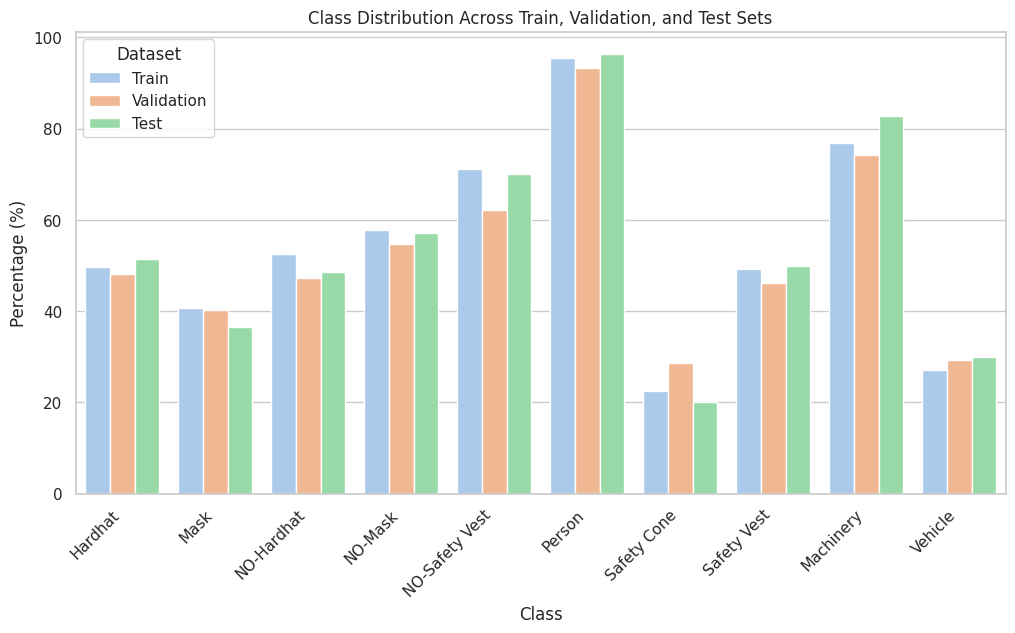

In [19]:
# Set theme and pastel color palette
sns.set_theme(style="whitegrid")  # Define o tema

# Calculate class distributions in percentage
def compute_class_percentage(df):
    total = len(df)
    return {cls: (df[cls].sum() / total) * 100 for cls in CFG.PPE_CLASSES.keys()}

train_percentages = compute_class_percentage(df_train)
valid_percentages = compute_class_percentage(df_valid)
test_percentages = compute_class_percentage(df_test)

# Convert to a DataFrame for Seaborn
df_plot = pd.DataFrame({
    "Class": list(CFG.PPE_CLASSES.values()) * 3,  # Repete as classes 3 vezes (para cada conjunto)
    "Percentage": list(train_percentages.values()) + list(valid_percentages.values()) + list(test_percentages.values()),
    "Dataset": ["Train"] * len(train_percentages) + ["Validation"] * len(valid_percentages) + ["Test"] * len(test_percentages)
})

# Create the plot using sns.barplot
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Percentage", hue="Dataset", data=df_plot, palette="pastel")

# Labels and formatting
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Class Distribution Across Train, Validation, and Test Sets")
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()


In [20]:
# Convert percentages to arrays
train_dist = np.array(list(train_percentages.values()))
valid_dist = np.array(list(valid_percentages.values()))
test_dist = np.array(list(test_percentages.values()))

# Compute standard deviation (how spread out the class distributions are)
train_std = np.std(train_dist)
valid_std = np.std(valid_dist)
test_std = np.std(test_dist)

# Compute Coefficient of Variation (CV) to assess balance
train_cv = (train_std / np.mean(train_dist)) * 100
valid_cv = (valid_std / np.mean(valid_dist)) * 100
test_cv = (test_std / np.mean(test_dist)) * 100

# Compute Jensen-Shannon divergence between Train-Valid and Train-Test
jsd_train_valid = jensenshannon(train_dist, valid_dist)
jsd_train_test = jensenshannon(train_dist, test_dist)

# Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Train: {train_std:.2f}, Valid: {valid_std:.2f}, Test: {test_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Train: {train_cv:.2f}%, Valid: {valid_cv:.2f}%, Test: {test_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better):")
print(f"   Train vs Valid: {jsd_train_valid:.4f}, Train vs Test: {jsd_train_test:.4f}")


📊 Standard Deviation of Class Distribution:
   Train: 21.19, Valid: 18.94, Test: 22.34

📊 Coefficient of Variation (Lower is better):
   Train: 39.02%, Valid: 36.13%, Test: 41.15%

📊 Jensen-Shannon Divergence (Lower is better):
   Train vs Valid: 0.0276, Train vs Test: 0.0209


**Now the datasets are clearly better stratified**

In [21]:
for folder in CFG.FOLDERS:
    os.makedirs(os.path.join(CFG.WORKING_PATH, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(CFG.WORKING_PATH, folder, "labels"), exist_ok=True)

# Function to move files to the correct locations
def move_files(df, subset):
    for _, row in df.iterrows():
        filename = row["filename"]
        origin = row["origin"]

        # Define source paths
        img_src = os.path.join(CFG.CSS_DATA_PATH, origin, "images", filename + ".jpg")
        label_src = os.path.join(CFG.CSS_DATA_PATH, origin, "labels", filename + ".txt")

        # Define destination paths
        img_dst = os.path.join(CFG.WORKING_PATH, subset, "images", filename + ".jpg")
        label_dst = os.path.join(CFG.WORKING_PATH, subset, "labels", filename + ".txt")

        # Move the files
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)
        else:
            print(f"⚠️ Image not found: {img_src}")

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)
        else:
            print(f"⚠️ Label not found: {label_src}")

# Move the files for train, valid, and test
move_files(df_train, "train")
move_files(df_valid, "valid")
move_files(df_test, "test")

print("✅ Dataset reorganization complete!")


✅ Dataset reorganization complete!


In [22]:
# ✅ Store the original class distribution BEFORE augmentation
original_class_counts = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}

for _, row in df_train.iterrows():
    for cls in CFG.PPE_CLASSES.keys():
        if row[cls] == 1:
            original_class_counts[cls] += 1

# ✅ Convert to numpy array for later comparison
original_counts = np.array(list(original_class_counts.values()), dtype=np.float64)

In [23]:
original_counts

array([       1112,         911,        1175,        1295,        1597,        2142,         504,        1105,        1721,         610])

In [24]:
# Invert class dictionary (name → id)
PPE_CLASSES_INV = {v: k for k, v in CFG.PPE_CLASSES.items()}

# Classes for augmentation
target_classes = ["Safety Cone", "Vehicle"]
excluded_classes = ["Person", "Machinery"]

# Directories for images and labels
img_dir = os.path.join(CFG.WORKING_PATH, "train", "images")
label_dir = os.path.join(CFG.WORKING_PATH, "train", "labels")

# Counter for cloned images
cloned_count = 0

# Create new images and labels for augmentation
for _, row in df_train.iterrows():
    filename = row["filename"]

    # Check if the image contains at least one of the target classes
    contains_target = any(row[PPE_CLASSES_INV[cls]] == 1 for cls in target_classes)
    
    # Allow images with up to 1 occurrence of "Person" or "Machinery"
    excluded_count = sum(row[PPE_CLASSES_INV[cls]] for cls in excluded_classes)
    
    if contains_target and excluded_count <= 1:
        # Define paths for image and label
        img_path = os.path.join(img_dir, filename + ".jpg")
        label_path = os.path.join(label_dir, filename + ".txt")

        if os.path.exists(img_path) and os.path.exists(label_path):
            # Read the original image
            img = cv2.imread(img_path)

            # Apply transformations: flipping, rotation, brightness
            augmentations = {
                "flipped": cv2.flip(img, 1),  # Horizontal flip
                "rotated": cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),  # Rotate 90 degrees
                "brightened": cv2.convertScaleAbs(img, alpha=1.2, beta=20)  # Increase brightness
            }

            for aug_type, aug_img in augmentations.items():
                # Create new filenames
                new_filename = f"{filename}_{aug_type}"
                new_img_path = os.path.join(img_dir, new_filename + ".jpg")
                new_label_path = os.path.join(label_dir, new_filename + ".txt")

                # Save augmented image
                cv2.imwrite(new_img_path, aug_img)

                # Copy label file (bounding boxes remain unchanged)
                with open(label_path, "r") as f:
                    label_data = f.readlines()

                with open(new_label_path, "w") as f:
                    f.writelines(label_data)

                cloned_count += 1

print(f"✅ {cloned_count} augmented images created (using flipping, rotation, and brightness adjustments).")

✅ 663 augmented images created (using flipping, rotation, and brightness adjustments).


In [25]:
# Define new DataFrame for augmented training set
df_train_augmented = []

# Paths for images and labels
train_img_dir = os.path.join(CFG.WORKING_PATH, "train", "images")
train_label_dir = os.path.join(CFG.WORKING_PATH, "train", "labels")

# Get all label files
label_files = glob.glob(os.path.join(train_label_dir, "*.txt"))

# Rebuild DataFrame by reading label files
for label_file in label_files:
    filename = os.path.basename(label_file).replace(".txt", "")

    # Read label file
    class_presence = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}
    with open(label_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID
            class_presence[class_id] = 1  # Mark presence of class

    # Append to new DataFrame
    row = {"filename": filename, "origin": "train"}
    row.update(class_presence)
    df_train_augmented.append(row)

# Convert to DataFrame
df_train_augmented = pd.DataFrame(df_train_augmented)

# Print summary
print(f"📊 New Train Dataset: {len(df_train_augmented)} images (after augmentation).")


📊 New Train Dataset: 2904 images (after augmentation).


📊 Standard Deviation of Class Distribution:
   Before: 474.96, After: 491.86

📊 Coefficient of Variation (Lower is better):
   Before: 39.02%, After: 31.31%

📊 Jensen-Shannon Divergence (Lower is better): 0.0494

📊 Relative Change per Class (%):
   Hardhat: 25.63%
   Mask: 28.32%
   NO-Hardhat: 27.83%
   NO-Mask: 29.19%
   NO-Safety Vest: 27.99%
   Person: 26.33%
   Safety Cone: 97.02%
   Safety Vest: 26.33%
   Machinery: 4.18%
   Vehicle: 69.84%


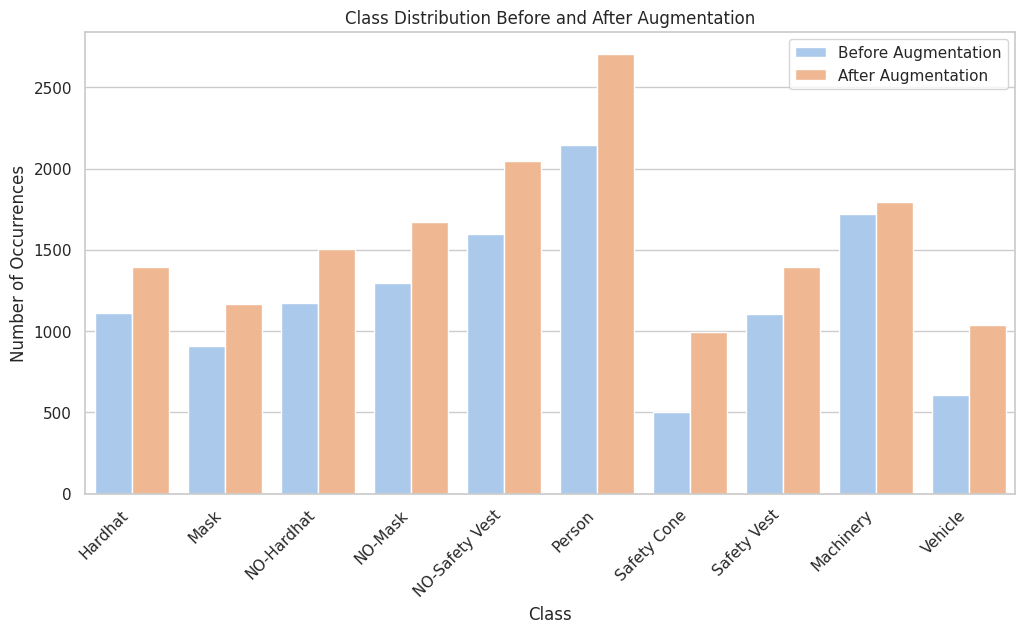

In [26]:
# ✅ Compute new class distribution from df_train_augmented
augmented_class_counts = {cls: 0 for cls in CFG.PPE_CLASSES.keys()}
for _, row in df_train_augmented.iterrows():
    for cls in CFG.PPE_CLASSES.keys():
        if row[cls] == 1:
            augmented_class_counts[cls] += 1

# Convert to numpy arrays
augmented_counts = np.array(list(augmented_class_counts.values()), dtype=np.float64)

# ✅ Compute standard deviation and coefficient of variation BEFORE augmentation
original_mean, original_std = np.mean(original_counts), np.std(original_counts)
original_cv = (original_std / original_mean) * 100

# ✅ Compute standard deviation and coefficient of variation AFTER augmentation
augmented_mean, augmented_std = np.mean(augmented_counts), np.std(augmented_counts)
augmented_cv = (augmented_std / augmented_mean) * 100

# ✅ Jensen-Shannon Divergence (Lower is better)
jsd = jensenshannon(original_counts, augmented_counts)

# ✅ Compute percentage change per class
relative_change = ((augmented_counts - original_counts) / original_counts) * 100

# ✅ Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Before: {original_std:.2f}, After: {augmented_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Before: {original_cv:.2f}%, After: {augmented_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better): {jsd:.4f}")

print("\n📊 Relative Change per Class (%):")
for cls, change in zip(CFG.PPE_CLASSES.values(), relative_change):
    print(f"   {cls}: {change:.2f}%")

# ✅ Plot class distribution BEFORE and AFTER augmentation
df_plot = pd.DataFrame({
    "Class": np.array(list(CFG.PPE_CLASSES.values())),  
    "Before Augmentation": original_counts,
    "After Augmentation": augmented_counts
})

# Melt for Seaborn
df_plot_melted = df_plot.melt(id_vars=["Class"], var_name="Dataset", value_name="Occurrences")

# ✅ Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Occurrences", hue="Dataset", data=df_plot_melted, palette="pastel")
plt.xlabel("Class")
plt.ylabel("Number of Occurrences")
plt.title("Class Distribution Before and After Augmentation")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()


In [27]:
# Paths to check
img_path = os.path.join(CFG.WORKING_PATH, "train", "images")
label_path = os.path.join(CFG.WORKING_PATH, "train", "labels")

# Count files
num_images = len([f for f in os.listdir(img_path) if f.endswith(".jpg")])
num_labels = len([f for f in os.listdir(label_path) if f.endswith(".txt")])

print(f"📂 Total images in train folder: {num_images}")
print(f"📂 Total labels in train folder: {num_labels}")


📂 Total images in train folder: 2904
📂 Total labels in train folder: 2904


In [28]:
# Load the YOLO11 model (pretrained weights)
model = YOLO(CFG.BASE_MODEL) 

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.5MB/s]


# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [29]:
### Save YAML file
def save_yaml_file(dataset_yaml, dataset_config):
    with open(dataset_yaml, "w") as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"✅ Dataset YAML file saved at: {dataset_yaml}")

### read yaml file created
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

In [30]:
# Define paths
dataset_yaml = os.path.join(CFG.WORKING_PATH, "dataset.yaml")

# Create YAML content
dataset_config = {
    "path": CFG.WORKING_PATH,  # Base path
    "train": "train/images",  # Train images folder
    "val": "valid/images",  # Validation images folder
    "test": "test/images",  # Test images folder
    "nc": len(CFG.PPE_CLASSES),  # Number of classes
    "names": list(CFG.PPE_CLASSES.values()),  # Class names
}

In [31]:
save_yaml_file(dataset_yaml, dataset_config)

✅ Dataset YAML file saved at: /kaggle/working/dataset.yaml


In [32]:
yaml_data = read_yaml_file(dataset_yaml)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- Machinery
- Vehicle
nc: 10
path: /kaggle/working/
test: test/images
train: train/images
val: valid/images



# Train

In [33]:
# Training parameters (used both in training and result logging)
train_data = {
    "epochs": CFG.EPOCHS,
    "batch": CFG.BATCH_SIZE,
    "imgsz": CFG.IMGSZ,
    "rect": CFG.RECT,
    "fraction": CFG.FRACTION,
    "seed": CFG.SEED,
    "verbose": CFG.VERBOSE,
    "show_labels": CFG.SHOW_LABELS,
    "show_conf": CFG.SHOW_CONF,
    "show_boxes": CFG.SHOW_BOXES,
    "device": CFG.DEVICE
}

In [ ]:
# Start timing the training
start_time = time.time()

train_results = model.train(
    data=dataset_yaml,
    **train_data
)

# End timing
end_time = time.time()
training_duration = end_time - start_time  # Calculate duration in seconds

Ultralytics 8.3.113 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/dataset.yaml, epochs=30, time=None, patience=100, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=False, show_conf=False, show_boxes=False, line

100%|██████████| 755k/755k [00:00<00:00, 16.9MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/train/labels... 2904 images, 17 backgrounds, 0 corrupt: 100%|██████████| 2904/2904 [00:02<00:00, 1361.34it/s]

train: /kaggle/working/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 519.6±201.6 MB/s, size: 52.9 KB)


val: Scanning /kaggle/working/valid/labels... 420 images, 6 backgrounds, 0 corrupt: 100%|██████████| 420/420 [00:00<00:00, 1259.82it/s]

val: /kaggle/working/valid/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.09G      1.526      3.284      1.595        344        640: 100%|██████████| 242/242 [00:37<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.16it/s]


                   all        420       5739      0.391       0.36        0.3      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.35G      1.472      2.212      1.578        191        640: 100%|██████████| 242/242 [00:34<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.89it/s]

                   all        420       5739      0.503      0.388      0.379      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.35G      1.428      2.026      1.556        217        640: 100%|██████████| 242/242 [00:34<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.11it/s]

                   all        420       5739      0.589      0.398       0.42      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.35G      1.406      1.954      1.532        314        640: 100%|██████████| 242/242 [00:34<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.28it/s]


                   all        420       5739      0.592      0.447      0.474      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.35G      1.385      1.876      1.517        306        640: 100%|██████████| 242/242 [00:33<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.22it/s]

                   all        420       5739      0.663      0.465      0.504      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.35G       1.35      1.825      1.495        248        640: 100%|██████████| 242/242 [00:33<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.05it/s]

                   all        420       5739      0.652      0.478      0.518      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.35G      1.327      1.761       1.47        259        640: 100%|██████████| 242/242 [00:33<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.39it/s]

                   all        420       5739      0.676      0.489      0.538       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.35G      1.303      1.706      1.457        316        640: 100%|██████████| 242/242 [00:33<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.45it/s]

                   all        420       5739      0.681      0.507      0.548      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.35G      1.291      1.682      1.447        230        640: 100%|██████████| 242/242 [00:33<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.56it/s]

                   all        420       5739      0.747      0.512      0.574      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.35G      1.283      1.632      1.428        354        640: 100%|██████████| 242/242 [00:34<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.54it/s]

                   all        420       5739      0.726      0.525      0.578      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.35G      1.242      1.576      1.408        230        640: 100%|██████████| 242/242 [00:33<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.70it/s]

                   all        420       5739      0.735      0.536      0.596      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.35G      1.249      1.566      1.413        220        640: 100%|██████████| 242/242 [00:33<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.23it/s]

                   all        420       5739       0.73      0.538      0.595      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.35G      1.229      1.534      1.394        331        640: 100%|██████████| 242/242 [00:33<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.60it/s]

                   all        420       5739      0.736      0.544      0.607      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.35G      1.216      1.515      1.394        249        640: 100%|██████████| 242/242 [00:33<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.49it/s]

                   all        420       5739      0.777      0.556      0.628       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.35G      1.208      1.485      1.378        270        640: 100%|██████████| 242/242 [00:33<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.81it/s]

                   all        420       5739      0.766      0.551      0.618      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.35G      1.202      1.467      1.372        172        640: 100%|██████████| 242/242 [00:33<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.65it/s]

                   all        420       5739      0.767      0.557      0.624       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.35G      1.248       1.52      1.398        352        640:   8%|▊         | 19/242 [00:02<00:32,  6.82it/s]

In [ ]:
# Store training metrics for later analysis
train_metrics = {
    "train_id": f"train_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}",  # Unique ID
    "model": CFG.BASE_MODEL,  # Model used
    "mAP50": train_results.box.map50,
    "mAP50-95": train_results.box.map,
    "Precision": train_results.box.mp,
    "Recall": train_results.box.mr,
    "train_time": round(training_duration, 2)  # Training duration in seconds
}

In [ ]:
# Display only the final summary metrics
print("\n📊 Final Training Metrics:")
for metric, value in train_metrics.items():
    if isinstance(value, (int, float)):  # Check if value is numeric
        print(f"   {metric}: {value:.3f}")
    else:
        print(f"   {metric}: {value}")  # Print as is if not numeric

In [ ]:
# Combine both training parameters and results into a new dictionary
train_summary = {**train_metrics, **train_data}

# Convert to DataFrame
train_df = pd.DataFrame([train_summary])

In [ ]:
# Append results if file exists, otherwise create a new one
if os.path.exists(CFG.TRAIN_RESULTS):
    existing_df = pd.read_csv(CFG.TRAIN_RESULTS)
    updated_df = pd.concat([existing_df, train_df], ignore_index=True)
else:
    updated_df = train_df

# Save the updated DataFrame
updated_df.to_csv(CFG.TRAIN_RESULTS, index=False)

# Print confirmation message
print(f"✅ Training results saved successfully to {CFG.TRAIN_RESULTS}")

In [ ]:
train_df = pd.read_csv(CFG.TRAIN_RESULTS)

In [ ]:
# Set display options to prevent line breaks
pd.set_option("display.width", 200)  # Increase display width
pd.set_option("display.max_columns", None)  # Show all columns

In [ ]:
print(train_df)

| Previous Trains Registry |
|--------------------------|

| train_id              |    model   |  mAP50   | mAP50-95 | Precision |  Recall  | train_time | epochs | batch | imgsz | rect  | fraction | seed | verbose | show_labels | show_conf | show_boxes | device |
|-----------------------|------------|----------|----------|-----------|----------|------------|--------|-------|-------|-------|----------|------|---------|-------------|-----------|------------|--------|
| train_20250212_200217 | yolo11m.pt | 0.200306 | 0.094233 |  0.308526 | 0.264851 |            |   3    |   4   | 640   | False |   0.05   |  42  |  False  |    False    |   False   |   False    |        |
| train_20250212_203757 | yolo11m.pt | 0.200306 | 0.094233 |  0.308526 | 0.264851 |            |   3    |   4   | 640   | False |   0.05   |  42  |  False  |    False    |   False   |   False    |  cuda  |
| train_20250212_204638 | yolo11m.pt | 0.200306 | 0.094233 |  0.308526 | 0.264851 | 102.07     |   3    |   4   | 640   | False |   0.05   |  42  |  False  |    False    |   False   |   False    |  cuda  |
| train_20250213_152347 | yolo11n.pt | 0.70718  | 0.467217 |  0.835532 | 0.628582 | 1211.92    |  30    |  12   | 640   | False |   1.0    |  42  |  False  |    False    |   False   |   False    |  cuda  |

# Saving the model as a Dataset

In [ ]:
# Saving the model as a Dataset
copyfile(CFG.MODEL_PATH, CFG.OUTPUT_MODEL_PATH)

In [ ]:
# Creating a metadata file
metadata = {
    "model": "YOLO11",
    "description": "Trained YOLO11 (yolo11n.pt) model on PPE detection dataset",
    "source": "Construction Site PPE detection w/ YOLO v11 notebook",
}
with open(CFG.METADATA_PATH, "w") as f:
    json.dump(metadata, f)

print(f"✅ Model saved to: {CFG.OUTPUT_MODEL_PATH}")

# 📌 Conclusion
---
Our **final trained YOLOv11n model** achieved **mAP50 of 70.72% and mAP50-95 of 46.72%**, demonstrating significant improvements in detecting PPE on construction sites. The results indicate that **fine-tuning hyperparameters** and **data augmentation strategies** positively impacted model performance.

Further improvements can be made by:
- Experimenting with **other augmentation techniques** to increase class diversity.
- Increasing **training epochs** to enhance model learning.
- Utilizing a **larger model**, such as YOLO11m.pt, if hardware resources allow.
- Testing on **real-world unseen images** to evaluate generalization.

With these refinements, the model can be further optimized for real-time PPE detection applications. 🚀

@misc{ construction-site-safety_dataset,
    title = { Construction Site Safety Dataset },
    type = { Open Source Dataset },
    author = { Roboflow Universe Projects },
    howpublished = { \url{ https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety } },
    url = { https://universe.roboflow.com/roboflow-universe-projects/construction-site-safety },
    journal = { Roboflow Universe },
    publisher = { Roboflow },
    year = { 2023 },
    month = { feb },
    note = { visited on 2023-02-23 },
}
